In [9]:
import torch
import torch.nn as nn
import numpy as np

ATTS = []

class self_attention(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation='relu'):
        super(self_attention,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        # self.query_linear = nn.Linear(in_dim,in_dim)
        # self.key_linear = nn.Linear(in_dim,in_dim)
        # self.value_linear = nn.Linear(in_dim,in_dim)
        # self.gamma = nn.Parameter(torch.zeros(1))

        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = 5 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = 5 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) 
        
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)        
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        avg = self.gamma*out
        out = self.gamma*out + x
        return out,avg


class net_one_neuron_transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=30, kernel_size=(5, 5), stride=(1, 1)),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(30),
            nn.Sigmoid(),
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels=30, out_channels=30, kernel_size=(5, 5), stride=(1, 1)),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(30),
            nn.Sigmoid(),
            nn.Dropout2d(0.3)
         ) #[N,30,9,9] 
        
        self.attention = self_attention(in_dim=30)

        self.layers_sa_reg = nn.Sequential(
            nn.BatchNorm2d(30),
            nn.Sigmoid(),
            nn.Dropout2d(0.3)
        )

        self.layers_2 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=30, kernel_size=(3, 3), stride=(1, 1)),
            nn.BatchNorm2d(30),
            nn.Sigmoid(),
            nn.Dropout2d(0.3), #or here
            nn.Conv2d(in_channels=30, out_channels=30, kernel_size=(3, 3), stride=(1, 1)),
            nn.BatchNorm2d(30),
            nn.Sigmoid(),
        )
        self.flatten = nn.Flatten()
        self.Linear = nn.Linear(5 * 5 * 30, 1)

    def forward(self, x):
        x = self.layers_1(x)
        x,a = self.attention(x) 
        ATTS.append(a)
        x = self.layers_sa_reg(x)
        x = self.layers_2(x)
        x = self.flatten(x)
        x = self.Linear(x)
        return x


class seperate_core_model_transformer(nn.Module):
    def __init__(self,num_neurons):
        super().__init__()
        self.models = nn.ModuleList([net_one_neuron_transformer() for i in range(num_neurons)])
        self.num_neurons = num_neurons

    def forward(self, x):
        outputs = [self.models[i].forward(x) for i in range(self.num_neurons)]
        outputs = torch.stack(outputs, dim=1)
        return outputs.reshape((outputs.shape[0], outputs.shape[1]))


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
from torch.utils.data import Dataset,DataLoader
from utils import *

num_neurons = 10
net = seperate_core_model_transformer(num_neurons=num_neurons)
net.load_state_dict(torch.load("./results/sascnn-5/model.pth"))

vimg = np.load('../all_sites_data_prepared/pics_data/val_img_m1s1.npy')
vresp = np.load('../all_sites_data_prepared/New_response_data/valRsp_m1s1.npy')
vimg = np.reshape(vimg,(1000,1,50,50))

In [11]:
img = torch.from_numpy(np.float32(vimg))
img[0:1].shape


torch.Size([1, 1, 50, 50])

In [12]:
with torch.no_grad():
    net.eval()
    print(net(img[0:1]))

tensor([[0.0264, 0.1030, 0.3821, 0.0908, 0.0978, 0.1012, 0.1131, 0.0473, 0.0924,
         0.0573]])


In [13]:
vresp.shape
print(vresp[0:10,0])

[ 0.03372375  0.13445296  0.09795013  0.08357424  0.06733206 -0.00465879
  0.02063589  0.08090114  0.03752996  0.02030124]


In [14]:
ATTS[0].shape

torch.Size([1, 30, 9, 9])

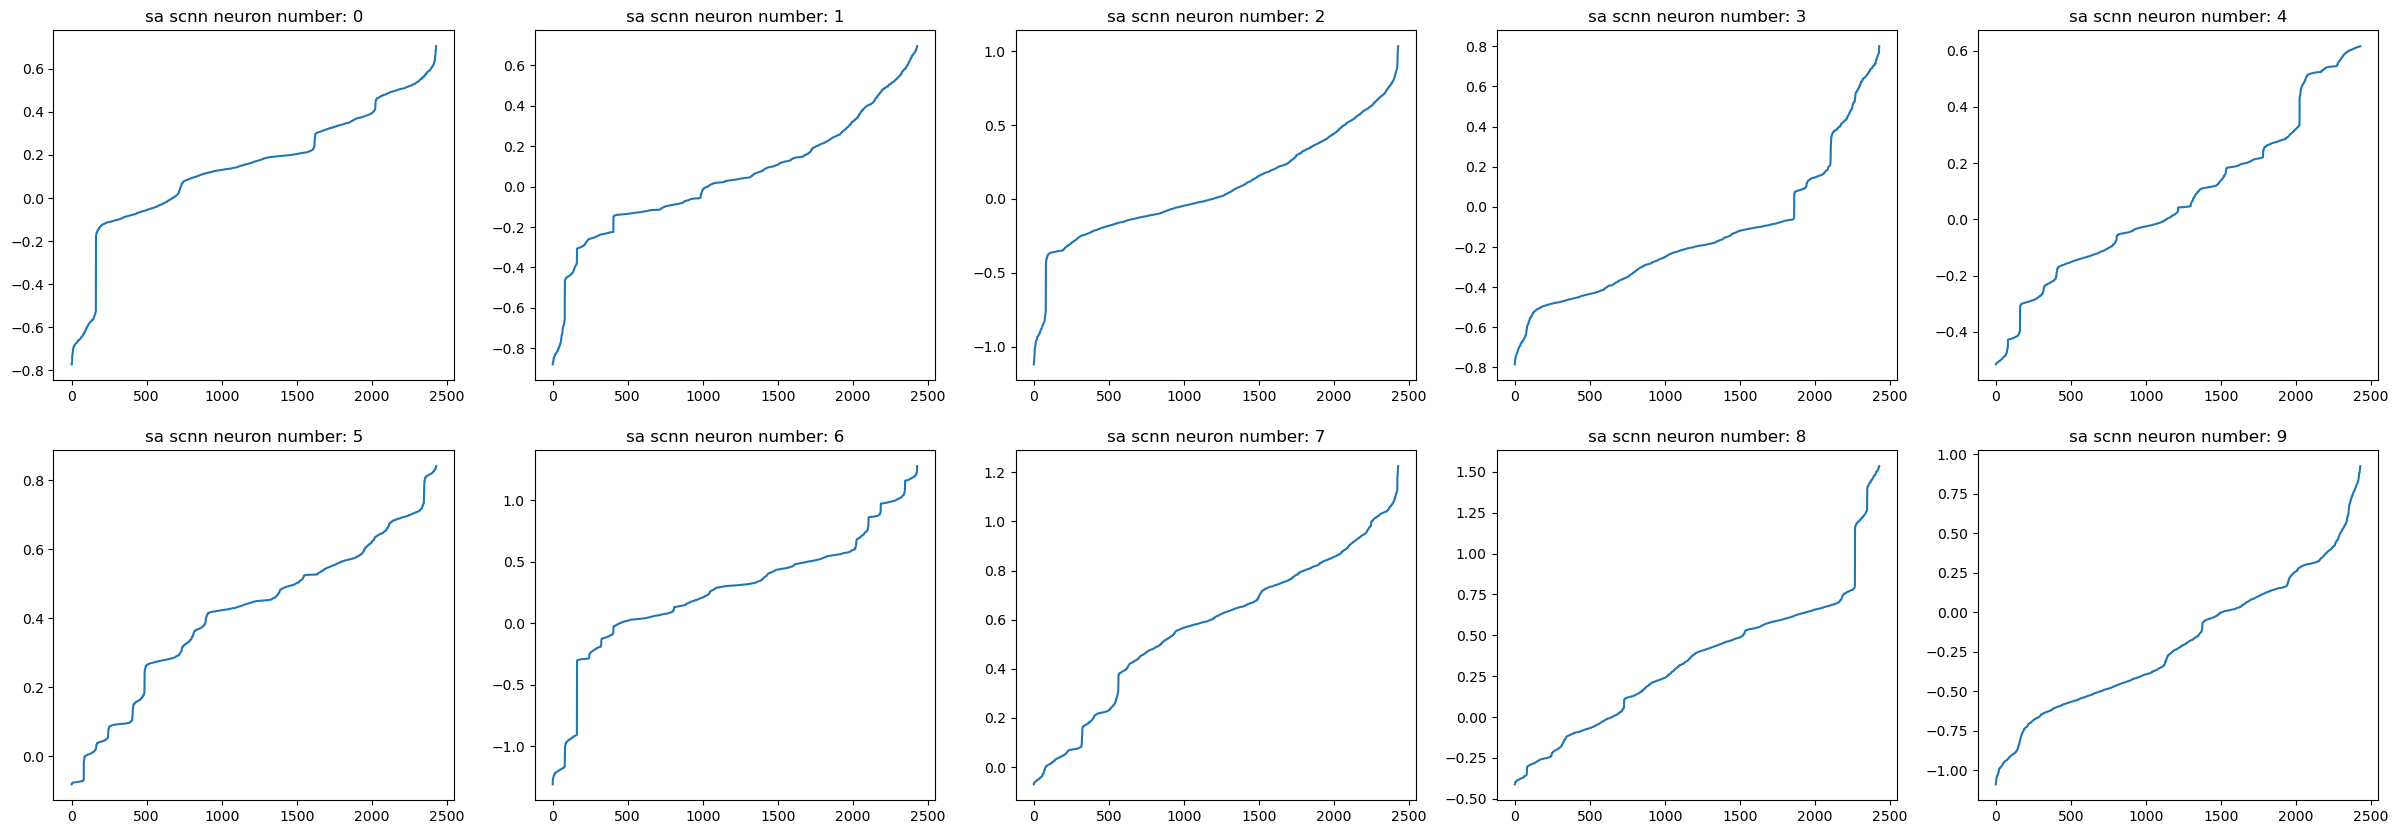

In [17]:
figure, axis = plt.subplots(2, 5, figsize=(30,10))

for neuron in range(10):
    axis[neuron//5,neuron%5].plot(sorted(ATTS[neuron].flatten()))
    axis[neuron//5,neuron%5].set_title("sa scnn neuron number: " + str(neuron))

plt.show()